In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyspark

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import udf

from pyspark.sql.types import FloatType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import regexp_replace
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import col,isnan, when, count


In [2]:
sc = pyspark.SparkContext()

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

#data = spark.read.option("header",True).option('inferSchema', True).csv("Google-Playstore.csv", sep =',')
#data = spark.read.option("header",True).option('inferSchema', True).json("cleaned.json")


In [4]:
sqlContext = SQLContext(spark)


In [5]:
data = spark.read.option("header",True).option('inferSchema', True).csv("Google-Playstore.csv")

In [6]:
data.printSchema()

root
 |-- App Name: string (nullable = true)
 |-- App Id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Count: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Minimum Installs: string (nullable = true)
 |-- Maximum Installs: string (nullable = true)
 |-- Free: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Minimum Android: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Developer Website: string (nullable = true)
 |-- Developer Email: string (nullable = true)
 |-- Released: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Privacy Policy: string (nullable = true)
 |-- Ad Supported: string (nullable = true)
 |-- In App Purchases: string (nullable = true)
 |-- Editors Choice: string (nullable = true)
 |-- Scra

In [7]:
data.dtypes

[('App Name', 'string'),
 ('App Id', 'string'),
 ('Category', 'string'),
 ('Rating', 'string'),
 ('Rating Count', 'string'),
 ('Installs', 'string'),
 ('Minimum Installs', 'string'),
 ('Maximum Installs', 'string'),
 ('Free', 'string'),
 ('Price', 'string'),
 ('Currency', 'string'),
 ('Size', 'string'),
 ('Minimum Android', 'string'),
 ('Developer Id', 'string'),
 ('Developer Website', 'string'),
 ('Developer Email', 'string'),
 ('Released', 'string'),
 ('Last Updated', 'string'),
 ('Content Rating', 'string'),
 ('Privacy Policy', 'string'),
 ('Ad Supported', 'string'),
 ('In App Purchases', 'string'),
 ('Editors Choice', 'string'),
 ('Scraped Time', 'string')]

In [8]:
# Prepariamo Installs e Content Rating alla trasformazione in numeriche
data = data.withColumn("Installs", regexp_replace(col("Installs"), "\+", ""))
data = data.withColumn("Installs", regexp_replace(col("Installs"), ",", ""))
data = data.withColumn("Rating", regexp_replace(col("Rating"), ",", ""))
data = data.withColumn("Size", regexp_replace(col("Size"), ",", "."))

data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "-1", "-1"))
data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "Everyone", "0"))
data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "Everyone 10+", "1"))
data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "Teen", "2"))
data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "Mature 17+", "3"))
data = data.withColumn("Content Rating", regexp_replace(col("Content Rating"), "Adults only 18+", "4"))

#Convertiamo in float...
data = data.withColumn("Price", data["Price"].cast(FloatType()).alias("Price"))
data = data.withColumn("Rating", data["Rating"].cast(FloatType()).alias("Rating"))
data = data.withColumn("Rating Count", data["Rating Count"].cast(FloatType()).alias("Rating Count"))
data = data.withColumn("Installs", data["Installs"].cast(FloatType()).alias("Installs"))
data = data.withColumn("Minimum Android", data["Minimum Android"][0:3].cast(FloatType()).alias("Minimum Android"))
data = data.withColumn("Content Rating", data["Content Rating"].cast(IntegerType()).alias("Content Rating"))


In [8]:
data = data.withColumnRenamed("Ad Supported", "adSupported")
data = data.withColumnRenamed("Minimum Android", "MinimumAndroid")
data = data.withColumnRenamed("In App Purchases", "inAppPurchases")
data = data.withColumnRenamed("App Name", "AppName")


In [91]:
data.describe().show()

+-------+--------------------+--------------------+--------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+--------------------+---------------+------------------+-------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+
|summary|             AppName|              App Id|      Category|            Rating|      Rating Count|            Installs|    Minimum Installs|    Maximum Installs|              Free|             Price|          Currency|              Size|    MinimumAndroid|        Developer Id|Developer Website|     Developer Email|       Released|      Last Updated|     Content Rating|         Privacy Policy|         adSupported|      inAppPurchases|      Editors Choice|       Scraped Time|
+-------+--------------------+

In [ ]:
data.dtypes

In [39]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+--------+------+--------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+------------+-----------------+---------------+--------+------------+--------------+--------------+------------+----------------+--------------+------------+
|App Name|App Id|Category|Rating|Rating Count|Installs|Minimum Installs|Maximum Installs|Free|Price|Currency|Size|Minimum Android|Developer Id|Developer Website|Developer Email|Released|Last Updated|Content Rating|Privacy Policy|Ad Supported|In App Purchases|Editors Choice|Scraped Time|
+--------+------+--------+------+------------+--------+----------------+----------------+----+-----+--------+----+---------------+------------+-----------------+---------------+--------+------------+--------------+--------------+------------+----------------+--------------+------------+
|       0|     0|       0| 22913|       22894|     108|             107|               0|   0|   19|     135| 196|          52764|      

## Basic statistics


In [ ]:
num_cols = ["Installs", "nReviews", "Rating", "Price", "MinimumAndroid", "Appeal"]

data.select(num_cols).describe().show()


In [ ]:
data.select(num_cols).summary().show()


In [ ]:
numeric_features = [x[0] for x in data.dtypes if x[1]=="int" or x[1]=="float" or x[1] == "double"]
sampled_data = data.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Plot

### Creazione di una vista per effettuare le query 

In [9]:
data.createOrReplaceTempView("viewPlot")

#### Numero di app in ciascuna categoria

In [41]:
categoryNumber = sqlContext.sql("""SELECT Category, COUNT(*) as tot 
                                    FROM viewPlot 
                                    GROUP BY category 
                                    ORDER BY tot desc""")
categoryNumber.show()

+-----------------+------+
|         Category|   tot|
+-----------------+------+
|        Education|241086|
|    Music & Audio|154905|
|            Tools|143987|
|         Business|143770|
|    Entertainment|138271|
|        Lifestyle|118331|
|Books & Reference|116726|
|  Personalization| 89210|
| Health & Fitness| 83510|
|     Productivity| 79695|
|         Shopping| 75253|
|     Food & Drink| 73926|
|   Travel & Local| 67288|
|          Finance| 65465|
|           Arcade| 53792|
|           Puzzle| 51168|
|           Casual| 50813|
|    Communication| 48167|
|           Sports| 47483|
|           Social| 44733|
+-----------------+------+
only showing top 20 rows



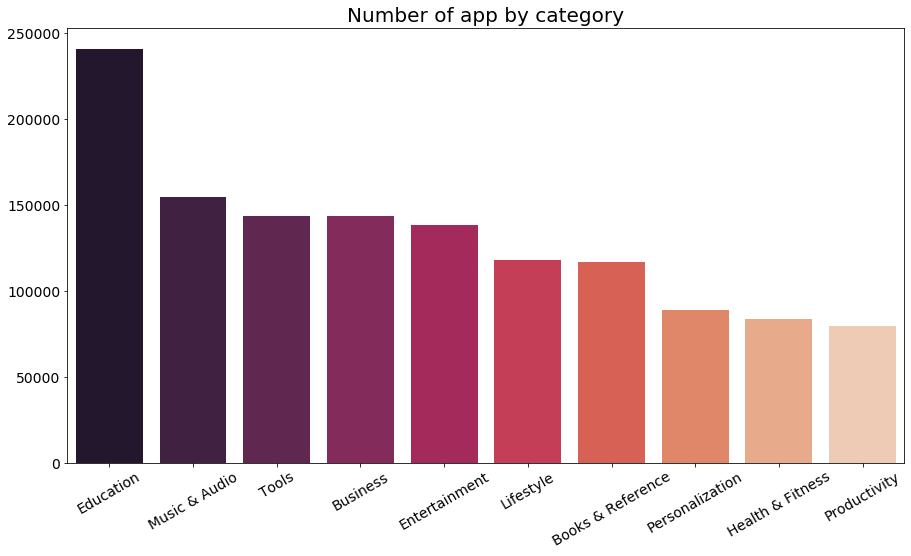

In [43]:
categoryNumberPlot = categoryNumber.toPandas()

plt.figure(figsize = (15,8))
sns.barplot(x = "Category", y = "tot", data  = categoryNumberPlot[:10], palette="rocket")
plt.xticks(rotation=30, fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel("")
plt.xlabel("")
plt.tight_layout
plt.title("Number of app by category", fontsize='20')
plt.show()

#### Appeal per categoria

In [25]:
appeal_category = sqlContext.sql("""SELECT category, Appeal
                                    FROM viewPlot 
                                    """)
plt.figure(figsize = (20,10))
appeal_category.show()

+-------------+------+
|     category|Appeal|
+-------------+------+
|Music & Audio|     0|
|Music & Audio|     1|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     1|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     1|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     1|
|Music & Audio|     0|
|Music & Audio|     0|
|Music & Audio|     1|
|Music & Audio|     0|
|Music & Audio|     1|
+-------------+------+
only showing top 20 rows



<Figure size 1440x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (15,8))

category_appeal_plot = appeal_category.toPandas()

sns.countplot(x='category',hue='Appeal',data=category_appeal_plot, palette="tab20b", 
             order=category_appeal_plot.category.value_counts().iloc[:10].index)
plt.xticks(rotation=30, fontsize='7')
plt.yticks(fontsize='8')
plt.ylabel("Number of app")
plt.title("Appeal by category")
plt.show()

#### Rating medio per categoria

In [9]:
categoryRating = data.groupBy("category").avg("rating").show()


+--------------------+------------------+
|            category|       avg(rating)|
+--------------------+------------------+
|       Music & Audio| 2.226824850719996|
|           Education|2.2468225311926124|
|              Trivia|2.5261784584102687|
|     Auto & Vehicles| 2.049612834137347|
|        Quick notes"|              null|
|       Entertainment|2.4354052028868614|
|fr.visionreelle.B...|              null|
|           Adventure| 2.814991004868682|
|com.free074a81ba9...|              null|
|              Arcade|2.4504809646643357|
|    CHEER UP(CCC)"""|              null|
|net.cleverbit.Mic...|              null|
|              Sports|2.3155445043837792|
|      Travel & Local|1.9211963940963501|
|        Food & Drink|1.2945808316654184|
|banglarhymes.ntss...|              null|
|        Role Playing|3.3844982885828023|
|               aves"|              null|
|             Finance|2.4030697207277085|
|     Personalization| 2.758753873719551|
+--------------------+------------

In [10]:
## visualiziamo anche le migliori app per categoria (partendo dalla top 5)

categoryRating = sqlContext.sql("""SELECT AppName, rating AS rating_avg, Installs
                                    FROM viewPlot 
                                    WHERE Category = 'Weather'
                                    ORDER BY rating_avg DESC, Installs DESC""")
categoryRating.show()

+--------------------+----------+---------+
|             AppName|rating_avg| Installs|
+--------------------+----------+---------+
|Flying Ghost Robo...|       5.0|1000000.0|
|Mechanical Excava...|       5.0|1000000.0|
|Flying Robot Supe...|       5.0|1000000.0|
|Wolf Robot Transf...|       5.0|1000000.0|
|Dog Robot Transfo...|       5.0| 500000.0|
|Ant Robot Car Tra...|       5.0| 500000.0|
|Car Wash Service ...|       5.0| 500000.0|
|Sand Safari Jeep ...|       5.0| 100000.0|
|Flying Limo Car T...|       5.0| 100000.0|
|FPS Commando Shoo...|       5.0| 100000.0|
|Dragon Robot Hors...|       5.0| 100000.0|
|Spider Crane Robo...|       5.0| 100000.0|
|Flying Horse Robo...|       5.0| 100000.0|
|Horse Robot Trans...|       5.0| 100000.0|
|Electric Car Stun...|       5.0|  50000.0|
|Heavy Trash Truck...|       5.0|  50000.0|
|US Police CyberTr...|       5.0|  50000.0|
|Dino Robot Car Ga...|       5.0|  50000.0|
|Emergency Fire Tr...|       5.0|  50000.0|
|Army Stuntman Bik...|       5.0

In [18]:
categoryRating = sqlContext.sql("""SELECT category, AVG(rating) AS rating_avg 
                                    FROM viewPlot 
                                    GROUP BY category
                                    ORDER BY rating_avg DESC""")
categoryRating.show()

+--------------------+------------------+
|            category|        rating_avg|
+--------------------+------------------+
|        Role Playing|3.3844982885828023|
|              Casino|3.2796822202241174|
|          Simulation|3.2108871649004502|
|             Weather| 3.120294525997836|
|                Card| 3.085160326385806|
|              Racing| 2.960233858728779|
|Video Players & E...|2.9038420088971755|
|                Word|2.9020762455428453|
|            Strategy| 2.878900084171941|
|              Comics|2.8649060628127647|
|           Adventure| 2.814991004868682|
|               Board|2.7821585888425138|
|     Personalization| 2.758753873719551|
|              Action|2.7059790497145757|
|              Puzzle|2.6882790595351738|
|               Music| 2.662008201359494|
|              Trivia|2.5261784584102687|
|         Photography|2.5197648766728986|
|    News & Magazines|2.4836006676483584|
|   Books & Reference| 2.467201757134877|
+--------------------+------------

In [46]:
categoryRatingPandas = categoryRating.toPandas()


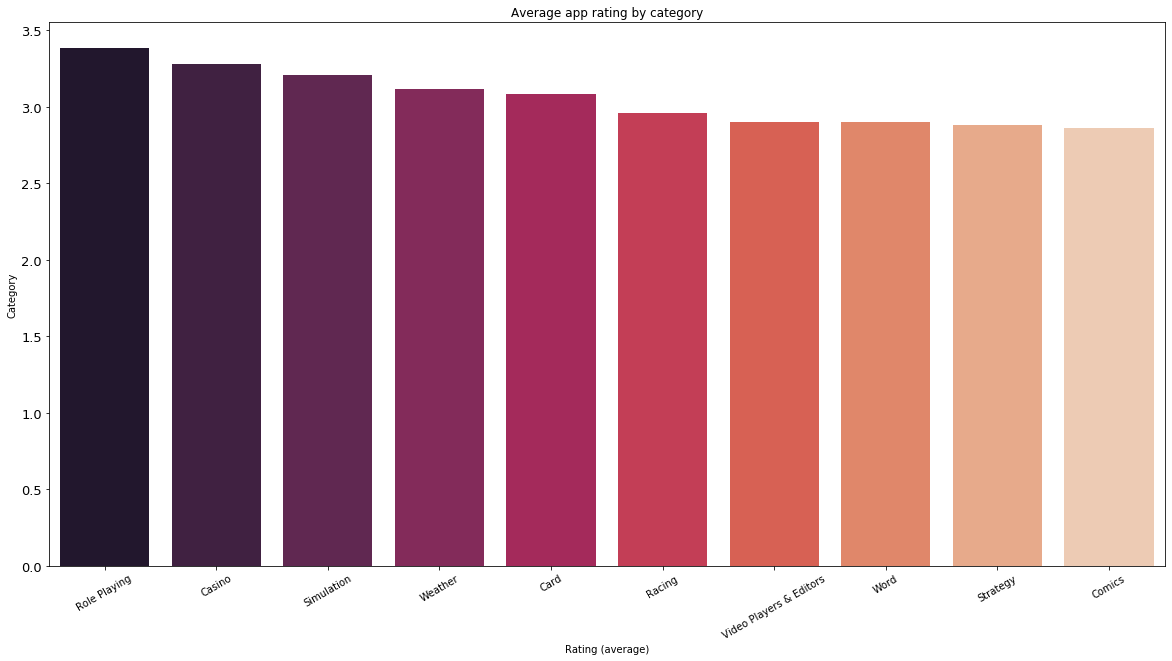

In [51]:
plt.figure(figsize = (20,10))
sns.barplot(x = "category", y = "rating_avg", data  = categoryRatingPandas[:10], palette="rocket")
plt.xticks(rotation=30, fontsize='10')
plt.yticks(fontsize='13')
plt.ylabel("Category")
plt.xlabel("Rating (average)")

plt.title("Average app rating by category")
plt.show()

In [52]:
categoryRatingPandas[categoryRatingPandas["category"]== "Education"]

,category,rating_avg
30,Education,2.246823


In [53]:
categoryRatingPandas[categoryRatingPandas["category"]== "Social"]

,category,rating_avg
27,Social,2.398922


### Ad Supported

In [149]:
adSupport = sqlContext.sql("""SELECT category, adSupported
                                FROM viewPlot 
                                """)
adSupport.show()

+-----------------+-----------+
|         category|adSupported|
+-----------------+-----------+
|        Adventure|      False|
|            Tools|       True|
|     Productivity|      False|
|    Communication|       True|
|            Tools|      False|
|           Social|      False|
| Libraries & Demo|       True|
|        Lifestyle|      False|
|    Communication|      False|
|  Personalization|       True|
|           Racing|      False|
|Maps & Navigation|      False|
|   Travel & Local|       True|
|Maps & Navigation|      False|
|   Travel & Local|      False|
|     Food & Drink|      False|
|   Travel & Local|      False|
|            Tools|      False|
|        Lifestyle|      False|
|Books & Reference|       True|
+-----------------+-----------+
only showing top 20 rows



In [144]:
adSupportPandas = adSupport.toPandas()


In [145]:
adsupp_dict = {"False": 0, "True": 1}
adSupportPandas['adSupported'] = adSupportPandas['adSupported'].map(adsupp_dict)


In [150]:
adSupportPandas.adSupported.value_counts()

0.0    1162150
1.0    1150750
Name: adSupported, dtype: int64

Text(0.5, 1.0, 'adSupported app')

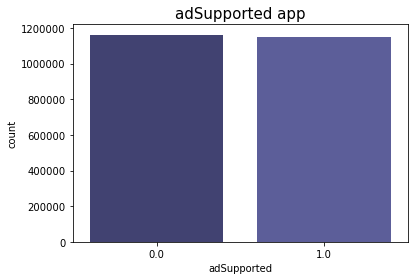

In [52]:
sns.countplot(x = adSupportPandas['adSupported'], palette='tab20b')
plt.title("adSupported app", fontsize='15')

In [89]:
ct = pd.crosstab(adSupportPandas.category, adSupportPandas.adSupported, margins=None)
norm_ct = ct.div(ct.sum(1).astype(float), axis=0)

Text(0.5, 1.0, 'AdSupported app ratio per category')

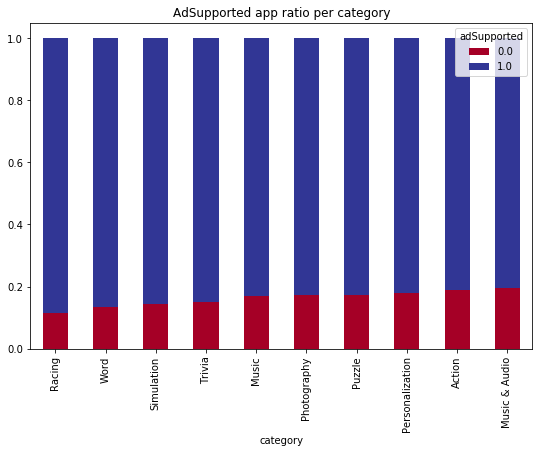

In [135]:
norm_ct.sort_values(by=0)[:10].plot(kind = "bar",stacked = True, figsize = (9, 6), colormap = "RdYlBu")
plt.title("AdSupported app ratio per category")

### Minimum Android Ver

In [162]:
minAndroid = sqlContext.sql("""SELECT category, MinimumAndroid
                                FROM viewPlot 
                                """)
minAndroid.show()

+-----------------+--------------+
|         category|MinimumAndroid|
+-----------------+--------------+
|        Adventure|           7.1|
|            Tools|           5.0|
|     Productivity|           4.0|
|    Communication|           4.0|
|            Tools|           4.1|
|           Social|           6.0|
| Libraries & Demo|           4.1|
|        Lifestyle|           5.0|
|    Communication|           4.4|
|  Personalization|           4.1|
|           Racing|           4.4|
|Maps & Navigation|           4.0|
|   Travel & Local|           4.2|
|Maps & Navigation|           6.0|
|   Travel & Local|           4.2|
|     Food & Drink|           4.4|
|   Travel & Local|           4.4|
|            Tools|           4.1|
|        Lifestyle|           4.1|
|Books & Reference|           4.2|
+-----------------+--------------+
only showing top 20 rows



In [185]:
minAndroidPandas = minumumAndroid.toPandas()


In [186]:
minAndroidPandas.MinimumAndroid.value_counts()

4.1      604525
4.4      402854
5.0      397006
4.0      334048
4.2      115980
6.0       89931
2.3       87197
5.1       59290
4.3       41363
7.0       34446
2.2       23770
3.0       17135
2.1       16719
8.0       13831
1.6        8549
2.0        3221
7.1        3044
3.2        2685
1.5        2100
3.1        2003
1.0         309
1.1         166
788.0         1
3.8           1
8.4           1
7.9           1
6.9           1
3.5           1
1.9           1
0.0           1
Name: MinimumAndroid, dtype: int64

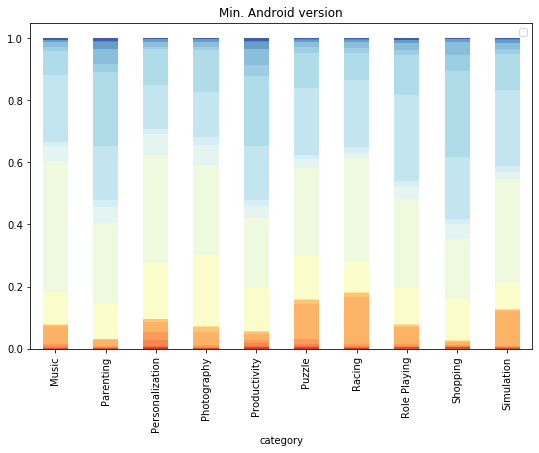

In [170]:
norm_ct = ct.div(ct.sum(1).astype(float), axis=0)
norm_ct.sort_values(by=0)[:10].plot(kind = "bar",stacked = True, figsize = (9, 6), colormap = "RdYlBu")
plt.title("Min. Android version")
plt.legend("")

### Price

In [101]:
avg_price_df = sqlContext.sql("""SELECT category, price
                                    FROM viewPlot 
                                    ORDER BY price DESC""")
avg_price_df.show()

+-----------------------+---------+
|               category|    price|
+-----------------------+---------+
|                   navi|5000000.0|
|              RK PAY"""|  10159.0|
| 마음을 다스리는 글"")"|   4106.0|
|           far high."""|   3725.0|
|         고양이 쇼핑몰"|   2108.0|
|     "" mp3 Collection"|    864.0|
|           Productivity|    400.0|
|           Productivity|   399.99|
|      Books & Reference|   399.99|
|                 Social|   399.99|
|                  Tools|   399.99|
|               Business|   399.99|
|                 Social|   399.99|
|          Entertainment|   399.99|
|               Shopping|   399.99|
|          Entertainment|   399.99|
|                 Arcade|   399.99|
|       Health & Fitness|   399.99|
|                 Casual|   399.99|
|                  Tools|   399.99|
+-----------------------+---------+
only showing top 20 rows



In [111]:
avg_price_pandas = avg_price_df.toPandas()


In [112]:
avg_price_pandas = avg_price_pandas[avg_price_pandas["price"]>0]

In [113]:
avg_price = avg_price_pandas.groupby("category").mean().sort_values(by= "price", ascending=True)


In [114]:
clean = avg_price[:-30]

In [115]:
clean = clean.sort_values(by= "price", ascending=False).reset_index()

In [116]:
clean

,category,price
0,Video Players & Editors,5.008850
1,Board,4.939353
2,Casino,4.755973
3,Word,4.703300
4,Role Playing,4.698225
5,Weather,4.499798
6,Communication,4.460425
7,Beauty,4.311429
8,Music & Audio,4.299316
9,House & Home,4.255781


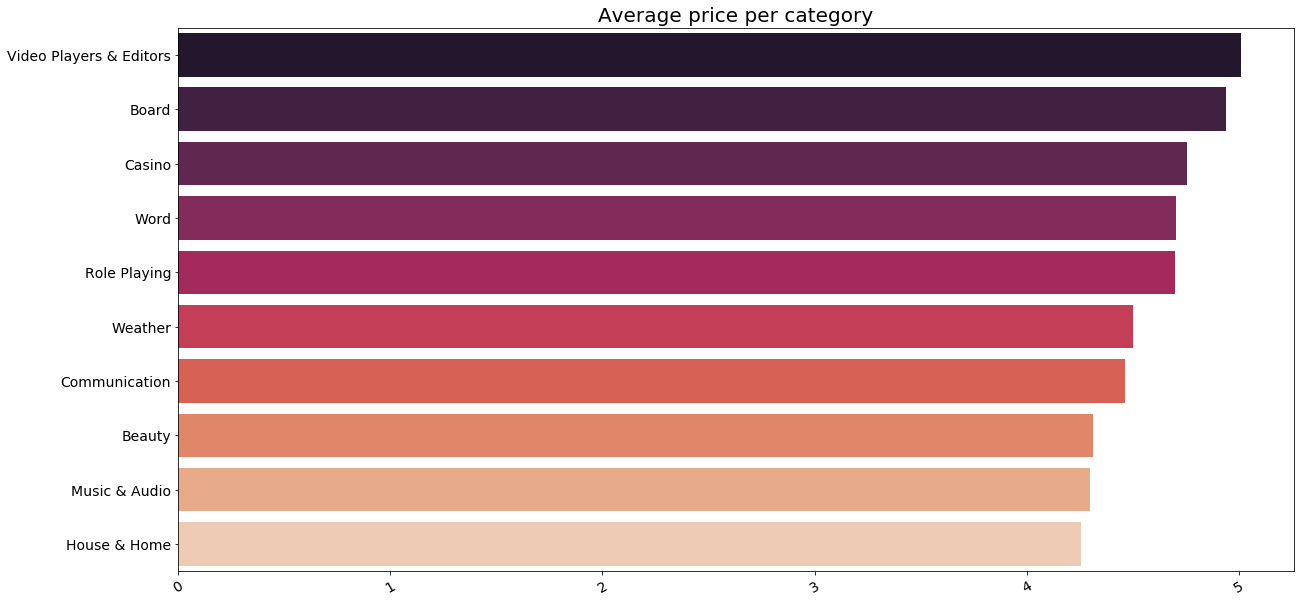

In [122]:
plt.figure(figsize = (20,10))
sns.barplot(x = "price", y = "category", data = clean[:10], palette="rocket")
plt.xticks(fontsize='14', rotation = 30)
plt.yticks(fontsize='14')
plt.xlabel("")
plt.ylabel("")

plt.title("Average price per category", fontsize = "20")
plt.show()

### In app 

In [95]:
inAppPurch = sqlContext.sql("""SELECT category, AVG(Price) AS avg_price
                                    FROM viewPlot 
                                    GROUP BY category
                                    ORDER BY avg_price DESC""")
inAppPurch.show()

+-----------------------+-------------------+
|               category|          avg_price|
+-----------------------+-------------------+
|                   navi|          5000000.0|
|              RK PAY"""|            10159.0|
| 마음을 다스리는 글"")"|             4106.0|
|           far high."""|             3725.0|
|         고양이 쇼핑몰"|             2108.0|
|     "" mp3 Collection"|              864.0|
|             коментарі"|              184.0|
|                  aves"|               89.0|
|       CHEER UP(CCC)"""|               15.0|
|           Quick notes"|               15.0|
|              Samurai]"|               10.0|
|                Medical| 0.7113878752016787|
|           Role Playing| 0.3118415148830376|
|                 Sports|0.22647534903029273|
|               Strategy|0.22537505574945607|
|      Books & Reference| 0.1932279309715364|
|              Adventure|0.17967864487626678|
|            Educational|0.17183981511271385|
|                  Board|0.16982376960560902|
| 

In [96]:
inAppPurchPandas = inAppPurch.toPandas()

In [97]:
inAppPurchPandas


,category,avg_price
0,navi,5000000.0
1,"RK PAY""""""",10159.0
2,"마음을 다스리는 글"""")""",4106.0
3,"far high.""""""",3725.0
4,"고양이 쇼핑몰""",2108.0
...,...,...
73,com.ud.parchis.publi,NaN
74,com.vsoapp.polls,NaN
75,com.bilgeyatirimci,NaN
76,com.blogspot.formyandroid.oknoty.widgets,NaN


In [98]:
pd.value_counts(inAppPurchPandas["InAppPurchases"]).plot.bar(color = "orange")
plt.xticks(rotation = 0)

KeyError: 'InAppPurchases'

## Correlation Matrix

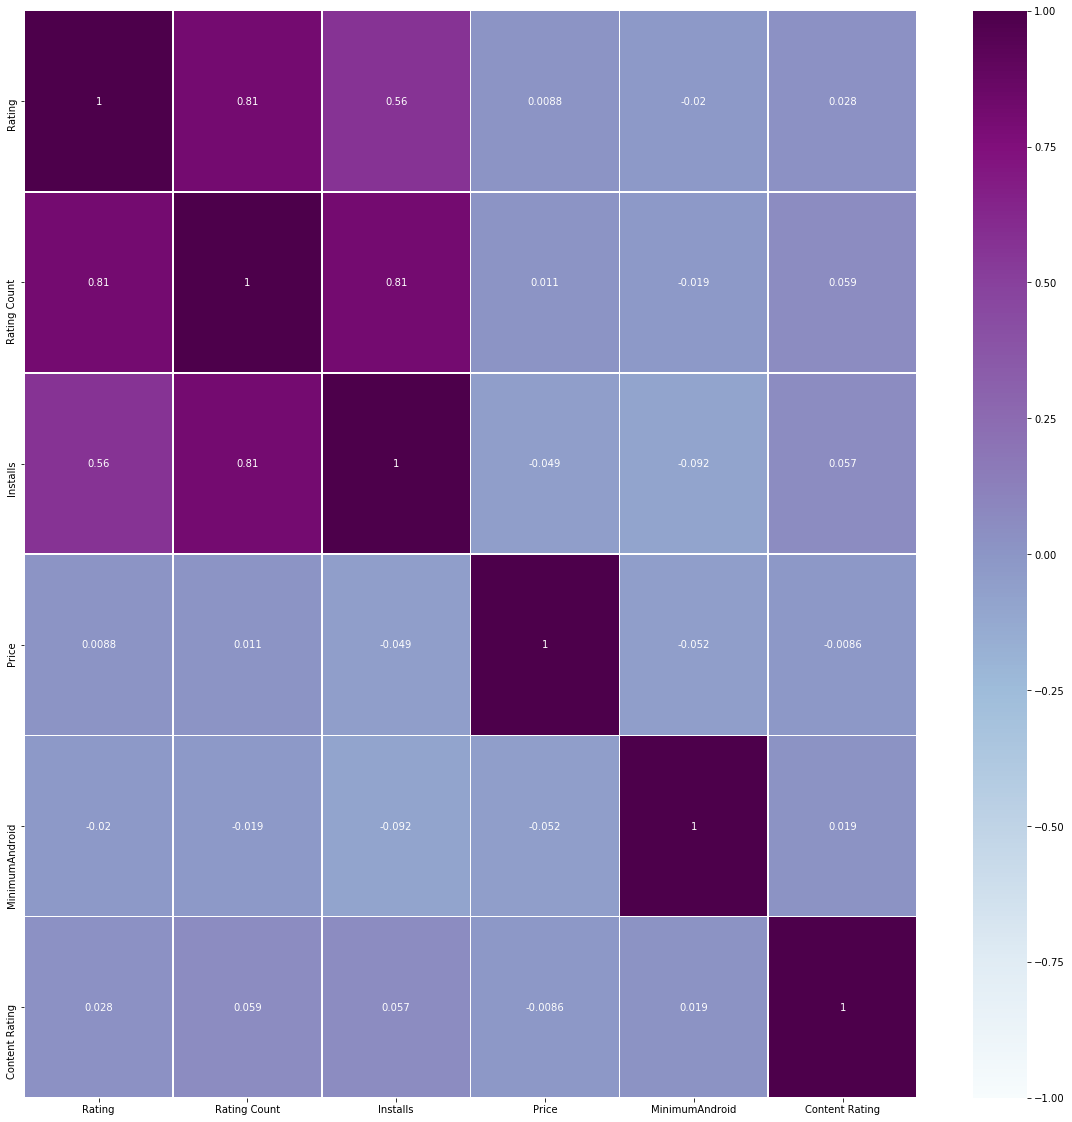

In [123]:
col_names = [x[0] for x in data.dtypes if x[1]=="int" or x[1]=="float" or x[1] == "double"]
features = data.select(col_names).rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="spearman")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
plt.figure(figsize = (20,20))
correlation = sns.heatmap(corr_df, cmap='BuPu', vmin=-1, vmax=1,annot=True, linewidths=.7)

# Analisi target variable per Classificazione

In [ ]:
data = spark.read.option("header",True).option('inferSchema', True).json("cleaned_v3.json")

In [ ]:
def getAppeal(value):
    """
    Defines target variable
    """
    if float(value) >= 3.5:
        return 1
    else:
        return 0
    
data = data.withColumn("Appeal", udf(getAppeal)("Rating"))
data = data.withColumn("Appeal", data["Appeal"].cast(IntegerType()))

In [ ]:
data.groupBy("Appeal").count().show()


In [ ]:
data.createOrReplaceTempView("viewPlot")
appeal_count = sqlContext.sql("""SELECT Appeal, COUNT(*) as count_Appeal 
                                    FROM viewPlot 
                                    GROUP BY Appeal 
                                    ORDER BY count_Appeal desc""")
appealPlot = appeal_count.toPandas()

In [ ]:
plt.figure(figsize = (6,5))
sns.barplot(x = "Appeal", y = "count_Appeal", data  = appealPlot, palette="tab20b")
plt.xticks(rotation=0, fontsize='10')
plt.yticks(fontsize='13')
plt.ylabel("Number of app")
plt.title("Appeal distribution")
plt.show()